# How to train a model with CellTypist

In [1]:
import scanpy as sc
import pandas as pd
import anndata as ad
import numpy as np
import itertools
from anndata import AnnData
from datetime import datetime
from typing import Optional, Union
from sklearn import __version__ as skv

import cytopus as cp

from scipy.sparse import spmatrix

from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics.cluster import adjusted_rand_score

import matplotlib.pyplot as plt
import plotly.graph_objects as go

import train
import annotate

There are a few key components to the Vanilla CellTypist model training: 
1. It is a Logistic Regression Classifier that uses Standard Gradient Dissent.
2. The classifer uses L2 regression 
3. The model is trained once on all the genes provided. Then it performs feature selection where the top 300 genes are selected for every cell type based on the coefficents from the classifer. The model is then retrained on the union of the selected genes and this produces the final model. 
4. It uses mini-batch training within each of the epochs

For a visual representation of this workflow, see figure 1c from the Conde et al. 2022 paper. 

In order to train a CellTypist model we need a dataset that has a couple necessary features. Most importantly, this dataset needs to have cell type annotations for each cell that the classifier will use when training the dataset. Additionally, CellTypist works with scRNAseq data so you will need a cellxgene matrix with the raw (or normalized) counts from scRNA sequencing. 

## SAIL train function vs the original CellTypist train function 

We added some features to the original CellTypist to add some desired functionality:
1. The primary addition is that the new train function also returns the list of genes that were chosen during feature selection (if feature selection doesn't happen, an empty dataframe is returned). 
2. It has the option to integrate Cytopus genes into the feature selection step. Cytopus is a Knowledge base of immune cell types and some of the commonly associated genes for each cell type. By ensuring that Cytopus genes are included in the feature selection, we are incorperating some prior knowledge into our model. This gene set can easily be changed to any previously gurated set of genes that you would like to ensure are included in the model.  
3. When training the classifier, we can now choose which sort of regularization to use (eg L1 instead of L2). Additionally, we can use one kind of normalization for the pre-feature selection training and then switch to a different kind for post-feature section training (either L2 -> L1 or L1 -> L2).
4. There is now the option to input raw data in AnnData form and then it will be normalized to median library size as part of preprocessing.


In terms of the actual mathematics behind the model, it is pretty much the same.

## Our Recommendations

### Data

The easiest type of data to work with when building a CellTypist model is AnnData saved as an h5ad file. The cell type annotations need to be saved in a column in .obs. 

In [2]:
#load the data
adata = ad.read('/data/peer/adamsj5/cell_typing/glasner_fine_annot.h5ad')
adata

AnnData object with n_obs × n_vars = 82991 × 25441
    obs: 'histology', 'Procedure_Type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'Phenograph_cluster', 'sample_number', 'hta_id', 'Gender', 'Ethnicity', 'Race', 'Smoking Status', 'Pack Years', 'Stage at Dx', 'Tissue Type', 'ProcedureType', 'Treatment Status', 'Tissue Site', 'tissue', 'hta_donor_id', 'organism', 'disease', 'development_stage', 'suspension_type', 'assay', 'cell_lineage', 'finer_cell_types', 'orig_cell_types'
    var: 'ribo', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable'
    uns: 'Phenograph_cluster_colors', 'dendrogram_Phenograph_cluster', 'neighbors', 'pca', 'sample_name_colors', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In terms of normalization, we recommend normalizing to median library size of your data (https://www.nature.com/articles/s41592-023-01814-1) or to 10,000 counts per cell and then log normalize. CellTypist expects you to normalize to 10,000 counts per cell (and also log normalize), so it will throw an error if the `check_expression` argument is set to True and it isn't normalized to the expected value. The `check_expression` argument defaults to False. Alternaitvately, you can also imput the raw data and set the `normalize` argument to True (default False). This will normlaize your data to median library size and then log normalize so you do not need to worry about it. 

In [3]:
# one way to check the normalization of your data:
np.expm1(adata.X[0]).sum() #the number this produces should be very close to the value you normalized to (just looking at the first cell)

9923.356

One more thing we recommend you check before moving onto model training is the names of the columns, which should be the gene names. Please ensure that your gene IDs are the actual gene names and not the Ensemble ID's or other similar ID forms. This will produce a model that is much more interperatable. To check, look at `.var_names` of you adata. If the variable names are the ensemble IDs, the gene names are often saved in a column in .var.

In [4]:
adata.var_names
#adata.var = adata.var.set_index('feature_name')

Index(['A1BG', 'A1CF', 'A2M', 'A2ML1', 'A3GALT2', 'A4GALT', 'A4GNT', 'AAAS',
       'AACS', 'AADAC',
       ...
       'ZWILCH', 'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11A', 'ZYG11B', 'ZYX',
       'ZZEF1', 'ZZZ3'],
      dtype='object', name='gene_name', length=25441)

Before fully committing to a model, we recommend setting aside a portion of the data to test on once the model is trained. To do this, you will need to randomly split your data into train and test data, which you can do with the `train_test_split()` function. By default, this model will split the cells 70/30, but you can change the percentage you want for training using the `frac` argument. The genes are not split between the two subsets. If you intend to train your model using a lsf job, you will need to save this data. 

In [5]:
train_data, test_data = train.train_test_split(adata)

#save
train_data.write_h5ad('/path/to/your/directory/train.h5ad')
test_data.write_h5ad('/path/to/your/directory/test.h5ad')

This version of the train function also allows you to confirm that a list of genes is included in the genes chosen during feature selection. We tested this using the genes from Cytopus, which is a Knowledgebase of immune cells. While we found that including cytopus genes did not have a significant impact on the model performance, this tool can be useful if there are genes that you need in your final model. There are some preliminary steps to take in order to be able to use this feature: you need to make those genes into a list, then confirm that they are included in the genes in your dataset.

In [6]:
# Make a list of all Cytopus genes 
G = cp.kb.KnowledgeBase()
cell_dict = G.identities

cp_genes = [i for i in cell_dict.values()]
cp_genes = list(itertools.chain(*cp_genes)) #make flatlist out of LoL
cp_genes = [x for x in cp_genes if str(x) != 'nan']
cp_genes = np.unique(cp_genes)

#confirm they these genes are included in the genes from the dataset
cp_genes_checked = [x for x in cp_genes if x in train_data.var_names]
cp_genes_checked = np.unique(cp_genes_checked)

KnowledgeBase object containing 75 cell types and 201 cellular processes



### Model Training

There are many, many variables for the train_modified function. Most, but not all, are described below. To see our final recommendations for first time model training, scroll to the bottom of the list. 
1. `X`: Path to the file to be annotate or a AnnData object already loaded into memory.
2. `labels`: Path to file with cell annotations, or an array/list in memory,  or to a column in `.obs` if X is an AnnData object
3. `genes`: Path to file with genes for columns, or an array/list in memory, or metadata if AnnData object (aka `.var_names`)
4. `transpose_input`: Whether to transpose X (aka if it is genexcell) 
5. `with_mean`: Whether to subtract mean values during data scaling 
6. `check_expression`: Whether to check if the matrix is normalized as expected
9. `max_iter`: *ignore if `use_SGD = True` & `mini_batch = True`* Maximum number of iterations before reaching the minimum of the cost function. Default increases as number of cells decreases
10. `n_jobs`: Number of CPUs used
11. `use_SGD`: Whether or not to use SGD during training of the classifier 
12. `alpha`: *ignore if `use_SGD = False`* Strength of L2 regularization
14. `mini_batch`: *ignore if `use_SGD = False`* Whether or not to use mini-batches during model training
15. `batch_number`: *ignore if `use_SGD = False` & `mini_batch = False`* The number of batches per epoch
16. `batch_size`: *ignore if `use_SGD = False` & `mini_batch = False`* The number of cells within each batch
17. `epochs`: *ignore if `use_SGD = False` & `mini_batch = False`* The number of epochs
18. `balance_cell_type`: *ignore if `use_SGD = False` & `mini_batch = False`* Whether to balance the cell type frequencies in mini-batches during each epoch so that rarer cell types will be sampled more
19. `feature_selection`: Whether to perform feature selection after the first round of training and then train again using only those features
20. `top_genes`: *ignore if `feature_selection = False`* The number of genes to select for each cell type based on their classifer coefficents 
21. `penalty`: Which regularization method to use
22. `switch_penalty`: Whether to switch the type of regualarization for the second round of model training 
24. `use_additional`: Whether to confirm that an external list of genes are included during feature selection
26. `additional_genes`: *ignore if `use_additional = False`* List of gene names from the external list 
27. `normalize`: *ignore if `X` is not an AnnData object* Whether or not to normalize the data in prepare_data()

We recommend `train_modified(X = <X>, labels = <LABELS>, genes = <GENES>, check_expression = False, use_SGD = True, mini_batch = True, balance_cell_type = True, feature_selection = True)` which is essentially how the Teich lab trained their original CellTypist Models.

In [7]:
model, genes = train.train_modified(X = train_data.X, labels = train_data.obs['finer_cell_types'], genes = train_data.var_names, check_expression = False, use_SGD = True, mini_batch = True, balance_cell_type = True, feature_selection = True)

🍳 Preparing data before training
👀 The input training data is processed as an array-like object


Check expression:  False
sum:  True


✂️ 1702 non-expressed genes are filtered out
🔬 Input data has 62243 cells and 23739 genes
⚖️ Scaling input data
🏋️ Training data using mini-batch SGD logistic regression
⏳ Epochs: [1/10]
⏳ Epochs: [2/10]
⏳ Epochs: [3/10]
⏳ Epochs: [4/10]
⏳ Epochs: [5/10]
⏳ Epochs: [6/10]
⏳ Epochs: [7/10]
⏳ Epochs: [8/10]
⏳ Epochs: [9/10]
⏳ Epochs: [10/10]
🔎 Selecting features
🧬 3667 features are selected
🏋️ Starting the second round of training
🏋️ Training data using mini-batch SGD logistic regression
⏳ Epochs: [1/10]
⏳ Epochs: [2/10]
⏳ Epochs: [3/10]
⏳ Epochs: [4/10]
⏳ Epochs: [5/10]
⏳ Epochs: [6/10]
⏳ Epochs: [7/10]
⏳ Epochs: [8/10]
⏳ Epochs: [9/10]
⏳ Epochs: [10/10]
✅ Model training done!


While it is possible to train models in your notebook, it will be much faster to train the model using an LSF job, especially for datasets larger than 100k cells. For an example python file and bsub script, see `train_model.py` and `script.sh` . It is important to save this model so you are able to use it again in the future,.

In [ ]:
model.write('/path/to/your/directory/model.pkl') #change to your dictionary 
genes.to_csv('/path/to/your/directory/genes.csv') #change to your dictionary 

### Annotating Test Data

In order to test the quality of the model, we need to use it to annotate the test data. For an indepth explanation of using CellTypist models to annotate datasets, see 'How To Use CellTypist Models.ipynb'. 

In [8]:
predictions = annotate.annotate(test_data, model = model)
adata_preds = predictions.to_adata()

⚠️ Warning: invalid expression matrix, expect all genes and log1p normalized expression to 10000 counts per cell. The prediction result may not be accurate
🔬 Input data has 20748 cells and 25441 genes
🔗 Matching reference genes in the model
🧬 3667 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!


If you would like to incorperate the list of genes used from the feature selection into your dataset, you can add it in the `.uns` component of the predictions adata object

In [9]:
adata_preds.uns['genes'] = genes

#remember to save
adata_preds.write_h5ad('/path/to/your/directory/data_with_predictions.h5ad')

### QC

Before actually using this new model, it is very important to confirm that it works well. There are a few analysis we recommend doing to ensure the quality of your model. 

First, we recommend looking at the F1 score and Adjusted Rand Index of your new annotations compared to the groundtruth. F1 scores are the standard metric used when benchmarking cell typing models. The two will likely not match up, but from experience they typically display similar trends. When the original CellTypist model was tested on the data it was trained on, it had an F1 score of about 0.9. 

In [10]:
#replace 'finer_cell_types' with the same of the column in obs that has the groundtruth annotations 
print(np.median(f1_score(adata_preds.obs['finer_cell_types'],adata_preds.obs['predicted_labels'], average=None)))
print(adjusted_rand_score(adata_preds.obs['finer_cell_types'], adata_preds.obs['predicted_labels']))

0.9046174916846018
0.9817293823345274


Next, we recommend looking at UMAPs coloured by the actual annotations and another by the predicted annotations to compare which cell types seem to have the most error. One thing to be aware of is that if the list of unique cell types isn't exactly the same between the two columns (eg every macrophage is labelled as a myeloid so one cell type is missing), the colour schemes of the two UMAPs will be slightly different and it will be a little harder to visually compare the two. 

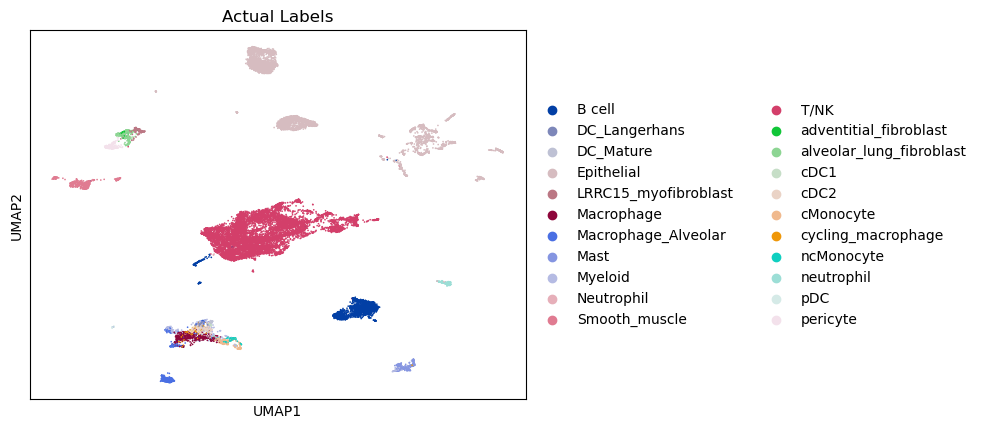

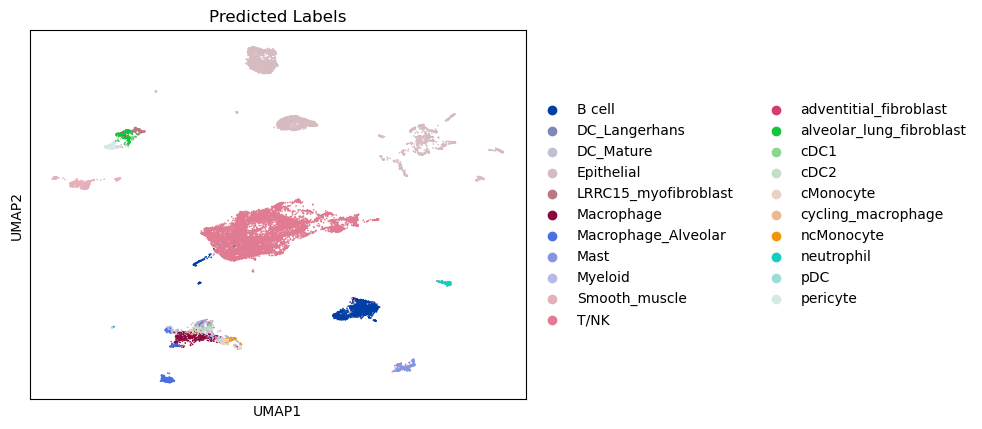

In [11]:
sc.pl.umap(adata_preds, color = ['finer_cell_types'], title = "Actual Labels")
sc.pl.umap(adata_preds, color = ['predicted_labels'], title = "Predicted Labels")

You can also colour the UMAP using the confidence score, which describes how confident the classifier was in labelling that cell. This is particularly useful when considered with the UMAP coloured by the the annotations; if you have identified a cluster that seems to be largely mislabelled that also mostly has high confidence scores, that is an indication that something about the model is not working well. 

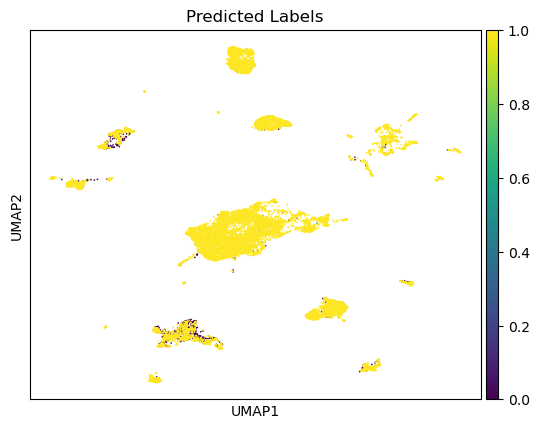

In [13]:
sc.pl.umap(adata_preds, color = ['conf_score'], title = "Predicted Labels")

If at any point concerns were raised about the model, there are a couple ways to look deeper into it to understand what is going on. The primary way would be to examine the genes that were feature selected for each cell type. There are a couple things to look at: 
1. Do these genes make sense for this cell type. This requires some knowledge about the cell types you are looking at and which genes are often associated with them. If they don't meet expectations, it may be in order to look over the original annotations to see if those are correct. 
2. Do similar cell types share a lot of genes. This may explain why cells of one cell type are often mislabelled as another related cell type. This is not as big of an issue as very dissimilar cell types getting mislabelled as each other. 
3. If you retrained the model on the same data without changing anything, are the genes chosen for each cell type largely similar. If not, this may mean that there is not a strong relationship between cell type and gene expression in your data 

In [ ]:
genes

This is not an exhaustive list of analyses to do to check how well your model performs. There are many more visualize your data in an informative way, such as Sankey plots and stacked bar plots, and the more indepth you look at your data, the more confident you can be in your model. These are good places to start. Once you are satisfied in your model performance, we recommend retraining the model on all of your data, without a holdout. 